In [15]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from Bio import SeqIO
import pandas as pd
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

In [5]:
def checkSlash(directory):
    if directory[-1] != '/':
        directory = directory + '/'
    return directory

def getAmphoraDNA(contigDir, amphoraDir, parallel):
    outFileName = amphoraDir.replace('/', '_DNA.sh')
    outFile = open(outFileName, 'w')
    outFile.write('#!/bin/bash\n#Amphora2 DNA sequence recovery commands\n\n')
    for subdir, dirs, files in os.walk(amphoraDir):
        for d in dirs:
            sampleID = d
            contigFile = contigDir + d + '_contigs.fna'
            outFile.write('./scripts/amphora_getDNA.py -a ' + \
                          amphoraDir + d + ' -c ' + contigFile + '\n')
    outFile.close()
    os.system('chmod +x ' + outFileName)
    os.system('cat ' + outFileName + ' | parallel --verbose -j ' + \
              str(parallel))

In [3]:
###GET_DNA
contigDir = '08_pseudo_contigs/'
amphoraDir = '09_amphora2_pseudo/'
parallel = 38
#getAmphoraDNA(contigDir, amphoraDir, parallel)

In [2]:
#In this dataset, 30 genes appear in all samples
def formatDNA(pseudoDir, inDir, outDir):
    pseudoContigs = []
    for f in os.listdir(checkDir):
        pseudoContigs.append(f.replace('_contigs.fa', ''))
    outDir = checkSlash(outDir)
    if not os.path.exists(outDir):
        os.makedirs(outDir)
    ####
    #Build collection of which functional genes are in which samples
    #fxnalGenes = {gene name: list of samples that have it}
    fxnalGenes = {}
    numGenomes = 0
    for subdir, dirs, files in os.walk(inDir):
        for d in dirs:
            if d in pseudoContigs:
                numGenomes += 1
                for f in os.listdir(inDir + d):
                    if '.fa' in f:
                        gene = f.replace('.fa', '')
                        if gene not in fxnalGenes:
                            fxnalGenes[gene] = [d]
                        else:
                            fxnalGenes[gene].append(d)
    ####
    #Only keep genes that exist in all samples
    #Also edit to remove short versions of the genes
    for gene in fxnalGenes:
        if len(fxnalGenes[gene]) != numGenomes:
            continue
        geneFile = open(outDir + gene + '_dna.fa', 'w')
        for d in fxnalGenes[gene]:
            records = SeqIO.parse(inDir + d + '/' + gene + '.fa', 'fasta')
            maxHeader = ''
            maxSeq = ''
            for r in records:
                if len(r.seq) > len(maxSeq):
                    maxHeader = r.id
                    maxSeq = str(r.seq)
            geneFile.write('>' + d + ' ' + maxHeader + '\n')
            geneFile.write(maxSeq + '\n')
        geneFile.close()
    return numGenomes

In [6]:
pseudoDir = '08_pseudo_contigs/'
inDir = '09_amphora2/'
outDir = '10_amphora_pseudo_aligned_DNA/'
numGenomes = formatDNA(pseudoDir, inDir, outDir)
print('Number of genomes: ' + str(numGenomes))

Number of genomes: 139


In [7]:
def alignDNA(inDir, parallel):
    #Align DNA sequences with Muscle
    #Create executable file to run in parallel
    outFileName = inDir.replace('/', '_alignDNA.sh')
    outFile = open(outFileName, 'w')
    outFile.write('#!/bin/bash\n#Amphora2 DNA alignment commands\n\n')
    for f in os.listdir(inDir):
        if '.fa' in f:
            outFile.write('muscle -in ' + inDir + f + ' -fastaout ' + \
                          inDir + f.replace('.fa', '_align.fa') + \
                          '\n')
    outFile.close()
    os.system('chmod +x ' + outFileName)
    os.system('cat ' + outFileName + ' | parallel --verbose -j ' + \
              str(parallel))

In [8]:
inDir = '10_amphora_pseudo_aligned_DNA/'
parallel = 38
alignDNA(inDir, parallel)

In [9]:
#Some samples appeared to fail alignment, are dropped out of analysis
def concatAlignments(inDir, numGenomes, outFile):
    if os.path.exists(outFile):
        os.system('rm ' + outFile)
    inDir = checkSlash(inDir)
    geneDict = {}
    for f in os.listdir(inDir):
        if '_dna_align.fa' in f:
            gene = f.replace('_dna_align.fa', '')
            geneDict[gene] = []
            records = list(SeqIO.parse(inDir + f, 'fasta'))
            for r in records:
                geneDict[gene].append(r.id)
    alignDict = {}
    for f in os.listdir(inDir):
        if '_dna_align.fa' in f:
            gene = f.replace('_dna_align.fa', '')
            if len(geneDict[gene]) == numGenomes:
                records = list(SeqIO.parse(inDir + f, 'fasta'))
                print(f + ': ' + str(len(records)))
                for r in records:
                    if r.id in alignDict:
                        alignDict[r.id] += r.seq
                    else:
                        alignDict[r.id] = r.seq
    outF = open(outFile, 'w')
    for s in alignDict:
        outF.write('>' + s + '\n')
        outF.write(str(alignDict[s]) + '\n')
    outF.close()

In [10]:
inDir = '10_amphora_pseudo_aligned_DNA/'
outFile = inDir + 'all_concatenated_dna_align.fa'
concatAlignments(inDir, numGenomes, outFile)

rplM_dna_align.fa: 139
nusA_dna_align.fa: 139
tsf_dna_align.fa: 139
rpsI_dna_align.fa: 139
rpsM_dna_align.fa: 139
rpsJ_dna_align.fa: 139
rplE_dna_align.fa: 139
frr_dna_align.fa: 139
rplP_dna_align.fa: 139
rplK_dna_align.fa: 139
rpsB_dna_align.fa: 139
rpmA_dna_align.fa: 139
rplS_dna_align.fa: 139
infC_dna_align.fa: 139
rplB_dna_align.fa: 139
rplF_dna_align.fa: 139
rplL_dna_align.fa: 139


In [11]:
inDir = '10_amphora_pseudo_aligned_DNA/'
inFile = inDir + 'all_concatenated_dna_align.fa'
records = list(SeqIO.parse(inFile, 'fasta'))
alignmentLen = len(records[0].seq)
print('Length of alignment, including gaps: ' + str(alignmentLen))

Length of alignment, including gaps: 10181


In [12]:
def buildPairwiseDiffs(inFile):
    records = list(SeqIO.parse(inFile, 'fasta'))
    rList = []
    for r in records:
        rList.append(r.id)
    df = pd.DataFrame(index=rList, columns=rList)
    for r1 in records:
        for r2 in records:
            #count = 0
            #i = 0
            #for i, base1 in enumerate(str(r1.seq)):
            #    if base1 != str(r2.seq)[i]:
            #        count += 1
            count = sum(1 for a, b in zip(r1.seq, r2.seq) if a != b)
            df.set_value(r1.id, r2.id, count)
    return df

In [13]:
inFile = inDir + 'all_concatenated_dna_align.fa'
df = buildPairwiseDiffs(inFile)
df.to_csv(inDir + 'pairwise_matrix.txt', sep = '\t')
df

,D17-102246,D17-102247,D17-102073,D17-102072,D17-102071,D17-102070,D17-102077,D17-102076,D17-102075,D17-102074,...,D17-102049,D17-102068,D17-102069,D17-102064,D17-102065,D17-102067,D17-102060,D17-102061,D17-102062,D17-102063
D17-102246,0,0,1227,2020,811,708,651,857,1029,759,...,694,714,708,725,694,698,859,759,698,840
D17-102247,0,0,1227,2020,811,708,651,857,1029,759,...,694,714,708,725,694,698,859,759,698,840
D17-102073,1227,1227,0,2390,1396,1260,895,1284,1455,1103,...,1101,1238,1260,1113,1101,1110,1290,1103,1110,1255
D17-102072,2020,2020,2390,0,2139,2049,1824,1914,2109,1355,...,1884,2025,2049,1866,1884,1894,1918,1355,1894,2002
D17-102071,811,811,1396,2139,0,489,797,1007,1178,919,...,802,520,489,903,802,810,1010,919,810,1028
D17-102070,708,708,1260,2049,489,0,653,908,1082,790,...,678,198,0,790,678,686,913,790,686,917
D17-102077,651,651,895,1824,797,653,0,829,1000,536,...,625,619,653,642,625,631,830,536,631,854
D17-102076,857,857,1284,1914,1007,908,829,0,205,641,...,637,923,908,683,637,648,12,641,648,404
D17-102075,1029,1029,1455,2109,1178,1082,1000,205,0,836,...,811,1095,1082,871,811,822,217,836,822,574
D17-102074,759,759,1103,1355,919,790,536,641,836,0,...,605,760,790,573,605,615,645,0,615,748


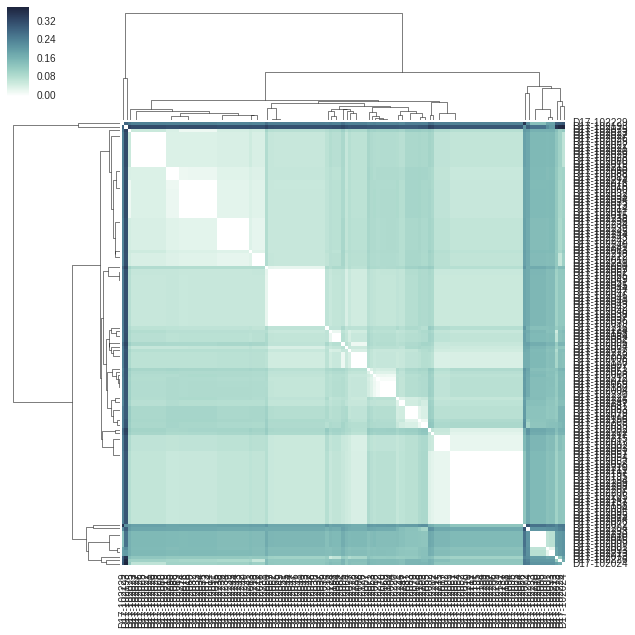

In [16]:
inFile = '10_amphora_pseudo_aligned_DNA/pairwise_matrix.txt'
df = pd.read_csv(inFile, sep = '\t', index_col=0)
df_per_site = df.divide(alignmentLen)

#Plot heatmap of substitutions per site
outPDF = '10_amphora_pseudo_aligned_DNA/pairwise_matrix.pdf'
cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
fig = sns.clustermap(df_per_site, cmap=cmap)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
fig.savefig(outPDF)